## Textual Entailment Generation system training

In [1]:
import torch
from joint_seq2seq import *

import warnings, matplotlib
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline

config = {"BATCH_SIZE" : 32,
          "HID_DIM" : 512,
          "N_LAYERS" : 2,
          "ATTN_TYPE" : "luong",
          "ATTN_FUNC" : "dot",
          "DROPOUT" : 0.2}

##### Load datasets and Build the vocabulary.
You can pass a list of paths to train the model on several datasets or partitions of the same dataset (MultiNLI, SNLI). Data should be a .txt file. \
        We are building the vocabulary using both unique terms from the training data as well as N most frequent words from a pretrained Word2Vec model. Therefore, ``.build_vocabulary()`` method of our Vocabulary class, takes the ``min_freq`` to filter low frequency word in the training dataset, while the ``n_most_freq`` parameter tells how many word to extract from Word2Vec vocabulary. \
When initializing the Seq2Seq model, we will need to specify the number of words in the vocabulary that do not have a pretrained embedding.

In [2]:
# Load pretrained Word2Vec model
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [3]:
paths = [r".\snli_1.0_dev.txt", 
         r".\snli_1.0_train.txt"]

multi_train = JointDataset.load_dataset(paths)
len(multi_train)

Loading SNLI dataset.
Loading SNLI dataset.


186743

In [4]:
vocab = Vocabulary.build_vocabulary(multi_train, wv, min_freq=2, n_most_freq=10000)
oov_size = len(vocab.vocabulary) - vocab.pretrained.size(0)


Done!


#### Initiate Seq2Seq model and choose the loss and the optimizer to use

In [5]:
# set a seed and use a utility function to obtain deterministic results
SEED = 1234
set_all_seeds(SEED)

# use cuda device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"You are using {device} device")

# set up the model with parameters from config
model = Seq2Seq(oov_size, len(vocab.vocabulary),
                pretrained_w2v = vocab.pretrained,
                hidden_size = config["HID_DIM"],
                n_layers = config["N_LAYERS"],
                dropout = config["DROPOUT"],
                device = device)

# randomly initialize model parameters and move the model to cuda (if available)
model.apply(init_weights)
model = model.to(device)

# select an optimizer and a loss function for training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss(ignore_index = 0)

print(f'The seq2seq model has {count_parameters(model):,} trainable parameters')
model

You are using cuda device
The seq2seq model has 19,307,020 trainable parameters


Seq2Seq(
  (pretrained_embedding): Embedding(10000, 300, padding_idx=0)
  (trainable_embedding): Embedding(8812, 300)
  (encoder): EncoderRNN(
    (bilstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): DecoderLuong(
    (attn): GlobalAttention()
    (rnn): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
    (proj): Linear(in_features=1024, out_features=512, bias=True)
    (out): Linear(in_features=512, out_features=18812, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

#### Train the model and save as .tar

In [ ]:
torch.cuda.empty_cache()

train_history = []
valid_history = []
N_EPOCHS = 1

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, vocab, multi_train, optimizer, criterion, device, train_history, valid_history)
    valid_loss = evaluate(model, vocab, dev_data, criterion, device)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} ')
    print(f'\tValidation Loss: {valid_loss:.3f} ')

In [ ]:
torch.save({'model': model.state_dict(),
            'optimizer': optimizer.state_dict()},
           r".\checkpoint_Luong_2epochs.tar")

####  Load pretrained checkpoint

In [6]:
checkpoint = torch.load(r".\checkpoint_Luong_2epochs.tar")
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
model = model.to(device)

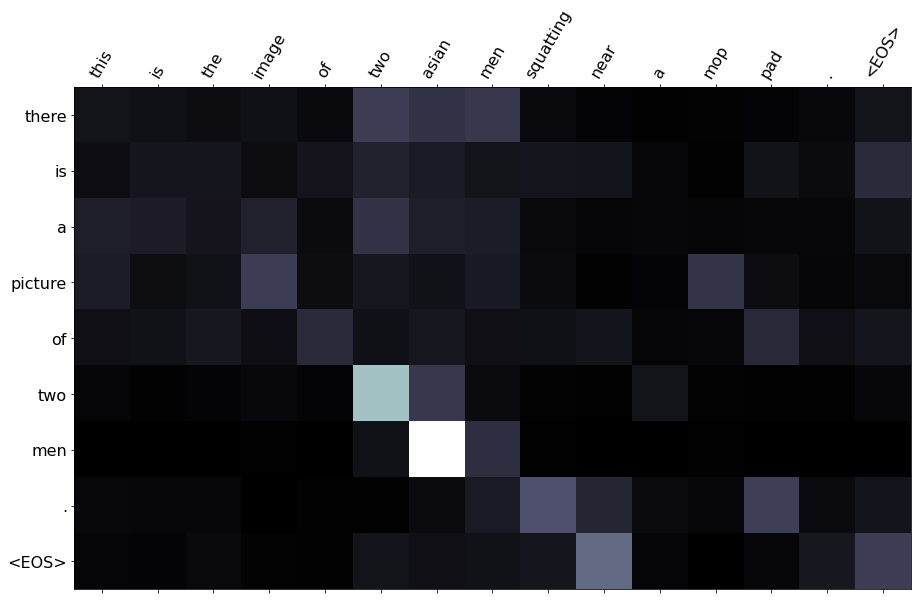

In [11]:
from display_results import display_attention

prem = multi_train[78][0]
hypo, attention = predict(prem, model, vocab, device, max_len=20)
display_attention(prem, hypo, attention)